# Preprare configs

This notebook supports the process of preparing config files.
The goals of the notebooks are as follows:
- extract selected frame(s) from the video
- define and test unwrapping parameters (camera view -> bird's eye view)
- define brid-eye to map transition parameters
- check the lane mask

In [ ]:
import sys
sys.path.insert(0,'..')

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from functions import *

%matplotlib inline

In [8]:
VIDEO_URL = 'rtsp://10.228.17.253/1'

In [9]:
cap = cv2.VideoCapture() 

cap.open(VIDEO_URL)
i = 0
while cap.isOpened():
    ret, image = cap.read()
    i += 1
    if i > 10:
        cv2.imwrite('./images/frame_view1.jpg', image)
        print ('Image saved!')
        break
cap.release()
    

Image saved!


Points for source (camera view) and destination (image view)
First four points are used for unwrapping, the rest is just display at tests

In [4]:
SRC = np.float32([
    [333, 371], # Right bottom
    [437, 255], # Right top
    [184, 271], # Left Top
    [10, 319], # Left bottom
    [355, 299], # Midpoint
])

DST = np.float32([
    [592, 430], # Right bottom
    [896, 369], # Right top
    [727, 232], # Left top
    [577, 238], # Left bottom
    [717, 378], # Midpoint
])


print ('  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(SRC[0][0]), int(SRC[0][1]),
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1])
))

print ('  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(DST[0][0]), int(DST[0][1]),
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]),
))



  "cameraPoints" : [[333, 371], [437, 255], [184, 271], [10, 319]],
  "birdEyePoints" : [[592, 430], [896, 369], [727, 232], [577, 238]],


In [8]:
M = cv2.getPerspectiveTransform(SRC[:4], DST[:4])
Minv = cv2.getPerspectiveTransform(DST[:4], SRC[:4])

[333. 371.] -> [592. 430.]
[437. 255.] -> [896. 369.]
[184. 271.] -> [727. 232.]
[ 10. 319.] -> [577. 238.]
[355. 299.] -> [716.17737 378.96512]


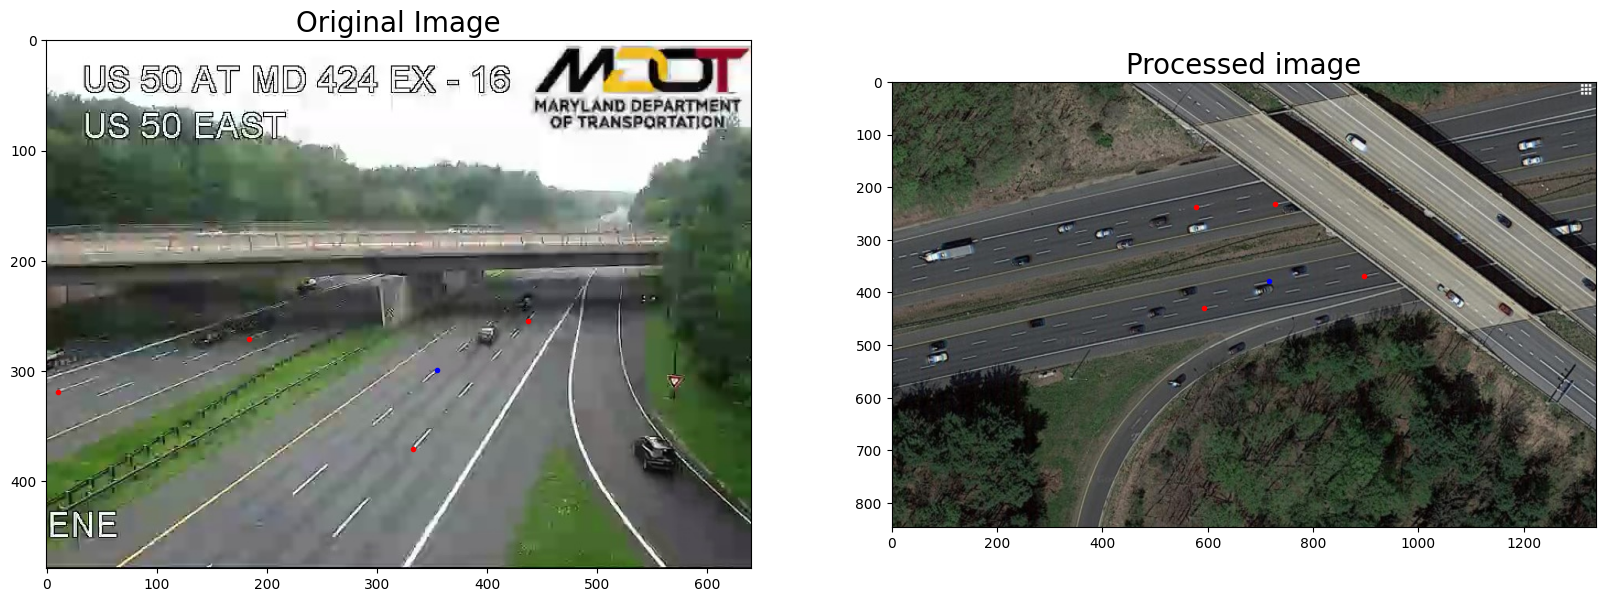

In [9]:
map_file = './images/SkyView.jpg'
ret = displayPoints(SRC, M, './images/frame_view1.jpg', map_file)

[592. 430.] -> [333. 371.]
[896. 369.] -> [437. 255.]
[727. 232.] -> [184. 271.]
[577. 238.] -> [ 10. 319.]
[717. 378.] -> [354.22037 298.5428 ]


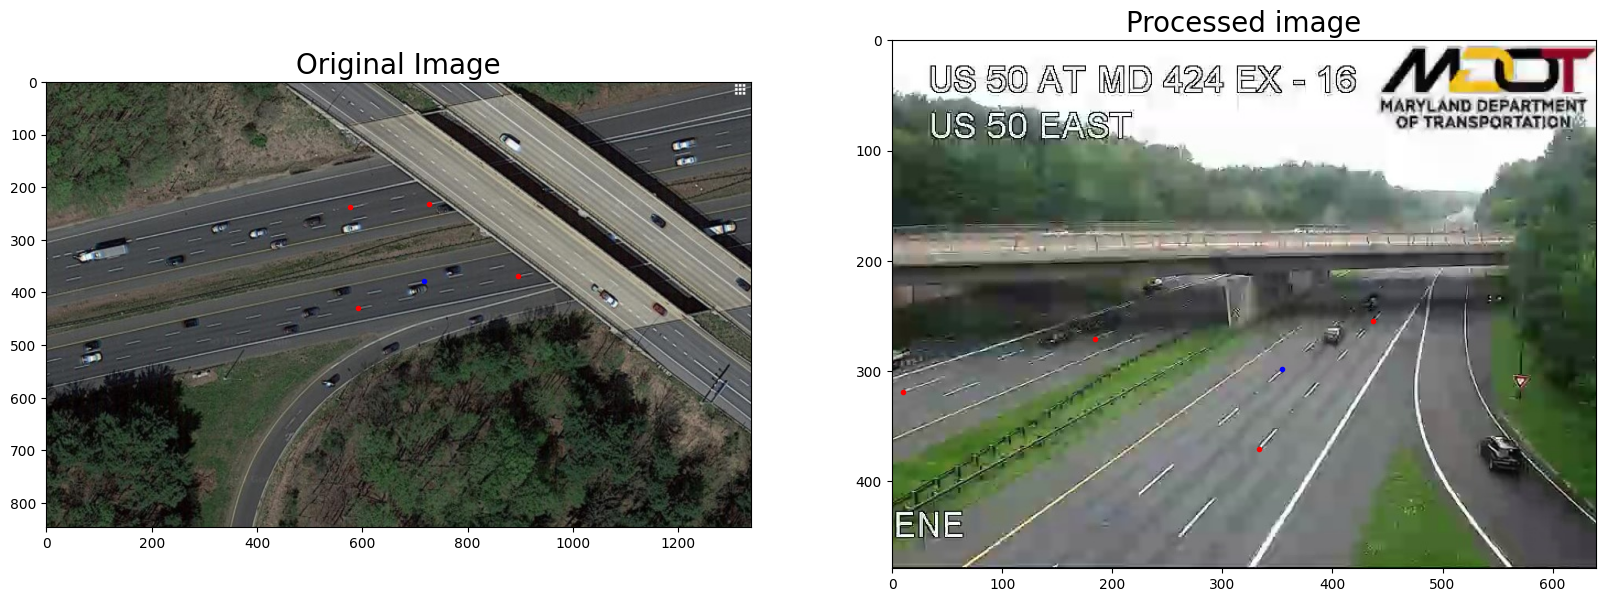

In [10]:
ret = displayPoints(DST, Minv, map_file,  './images/frame_view1.jpg')

# Below this comment is an old MoveOver Code only

# SkyView 2 Geocoordinates

In [ ]:
latlon1 = 45.743893, -122.660828
xy1 = 96, 30
latlon2 = 45.742497, -122.659864
xy2 = 635, 1151

# Lane masks

In [ ]:
MASK_PATH = './images/mask.png'

sys.path.insert(0,'../..')
from cav.parameters import Parameters
params = Parameters()
params.generateParameters('./params.json')


mask = (255*plt.imread(MASK_PATH)).astype(int)
if (len(mask.shape) == 3) and (mask.shape[2] > 1):
    #mask = np.sum(mask, axis=2)
    mask = mask[:, :, 0]
plt.imshow(mask, cmap='gray')
unique = np.unique(mask, return_counts=True)
print (unique)

if [0] + params.lanes_mask == sorted(unique[0]):
    print ('OK! Mask parameers defined correctly in params.json.')
else:
    print (f'json file : {[0] + params.lanes_mask}')
    print (f'from image : {sorted(unique)}')
    

### Create json file

In [ ]:
img = cv2.imread('./images/frame_view1.jpg')
skyview = cv2.imread('./images/SkyView.jpg')

jsonfile = '''{{
  "videoShape" : [{}, {}],
  "birdEyeViewShape" : [{}, {}],

  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],
  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],

  "birdEyeCoordinates" : [[{}, {}], [{}, {}]],
  "latLonCoordinates" : [[{}, {}], [{}, {}]],
  "elevation" : 40,
    
  "lanes_mask" : {}
}}'''.format(
    img.shape[1], img.shape[0], # videoShape
    skyview.shape[1], skyview.shape[0], # birdEyeViewShape
    
    int(SRC[0][0]), int(SRC[0][1]), # cameraPoints
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1]), # cameraPointsEnd 
    
    int(DST[0][0]), int(DST[0][1]), # birdEyePoints
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]), # birdEyePointsEnd
    
    xy1[0], xy1[1], xy2[0], xy2[1], #birdEyeCoordinates

    latlon1[1], latlon1[0], #latLonCoordinates
    latlon2[1], latlon2[0],
    
    str(sorted(unique[0])[1:]), # lanes_mask
)

with open('params.json', 'w') as f:
    for line in jsonfile.split('\n'):
        print (line)
        f.write(line + '\n')

